In [235]:
import numpy as np
from numpy.fft import fft,fftshift
import matplotlib.pyplot as plt
import math

In [236]:
def getOneSymbolBinarySubsequence(value, method):
        
    binValue = '{0:016b}'.format(abs(value))
    match method:
        # max: 2^(k-1)-1
        # min: -(2^(k-1)-1)
        case 'Signed Magnitude':
            if value > 0:
                binValue = binValue.replace(binValue[0], '0', 1)
            else:
                binValue = binValue.replace(binValue[0], '1', 1)
        # max: 2^(k-1)-1
        # min: -(2^(k-1)-1)
        case '1s Complement':
            if value < 0:
                invertBinValue = ''.join(['1' if i == '0' else '0' for i in binValue])
                binValue = invertBinValue
        # max: 2^(k-1)-1
        # min: -(2^(k-1))
        case '2s Complement':
            if value < 0:
                invertBinValue = ''.join(['1' if i == '0' else '0' for i in binValue])
                binValue = '{0:05b}'.format(int(invertBinValue, 2) + 1)
            
    return binValue

In [237]:
def getBinarySubsequence(int16Subsequence):
    binarySubsequence = []
    for i in range(0,len(int16Subsequence),1):
        if int16Subsequence[i] > 32767:
             binarySubsequence.append(getOneSymbolBinarySubsequence(0, '2s Complement'))
        else:
            binarySubsequence.append(getOneSymbolBinarySubsequence(int16Subsequence[i], '2s Complement'))
    binarySubsequence[0:len(int16Subsequence)] = [''.join(binarySubsequence[0:len(int16Subsequence)])]
    return binarySubsequence[0]

**Входные данные:**<br>
dataSubsequence --> Последовательность данных для передачи

In [238]:
sub = [12345, 156, 1679]
all = getBinarySubsequence(sub)

Baud rate это количество изменений сигнала или символов, передаваемых в секунду, т.е.
$$
Baud rate = \frac{number\;of\;signal\;elements}{total\;time\;(one\;second)}
$$
Количество отсчетов на один бит равно отношению длительности одного бита к периоду дискретизации, т.е.<br>
$$
samples = \frac{bit\;duration}{sampling\;period}
$$
, где<br>
$$
bit\;duration = \frac{1}{Baud\;rate}
$$
$$
sampling\;period = \frac{1}{sampling\;frequency}
$$


In [239]:
def getBinarySignal(binSubsequence, baudrate, Fsample = 2000):
    # init buffer
    binarySignal = []
    timeNumbers = []
    binSubsequence = list(binSubsequence)

    bitDuration = 1 / baudrate
    samplingPeriod = 1 / Fsample
    samples = int(bitDuration / samplingPeriod)
    
    for i in range(0, len(binSubsequence), 1):
        for time in range(0, samples, 1):
            if int(binSubsequence[i]) == 1:
                binarySignal.append(1)
            else:
                binarySignal.append(-1)
            timeNumbers.append(i * bitDuration + samplingPeriod * time)
            
    return(binarySignal, timeNumbers, samplingPeriod)

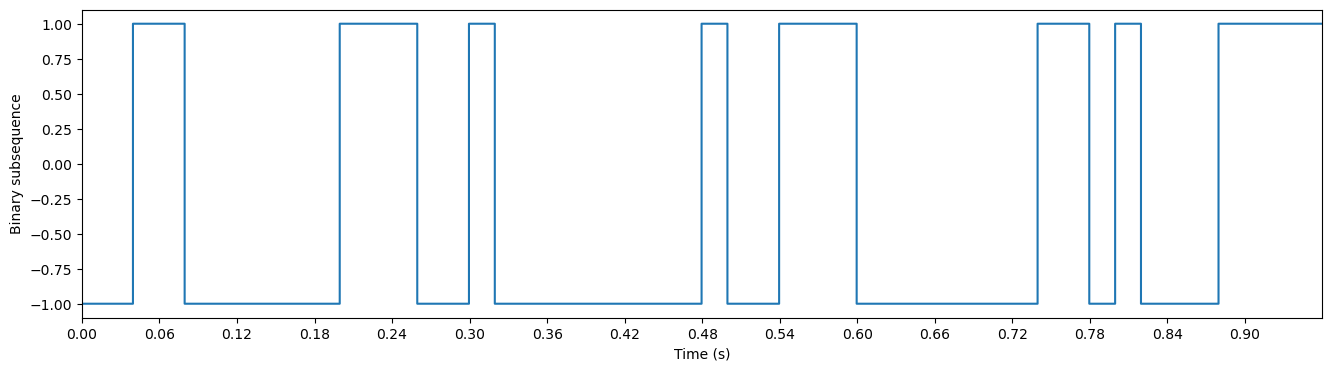

In [240]:
baudRate = 50
[binarySignal, timeNumbers, samplingPeriod] = getBinarySignal(all, baudRate)
fig,ax = plt.subplots(figsize = (16, 4))
ax.step(timeNumbers, binarySignal)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Binary subsequence')
ax.set_xlim(0, max(timeNumbers))
ax.set_xticks(np.arange(0, max(timeNumbers), len(sub)/baudRate))
plt.show()

In [241]:
#Модуляция сигнала
def getBPSKSignal(binarySignal, time, f0):
    ph0 = 0
    tnp = np.array(time)
    xnp = np.array(binarySignal)
    bpskSignal = xnp * np.sin(2 * np.pi * f0 * tnp + ph0)
    return bpskSignal

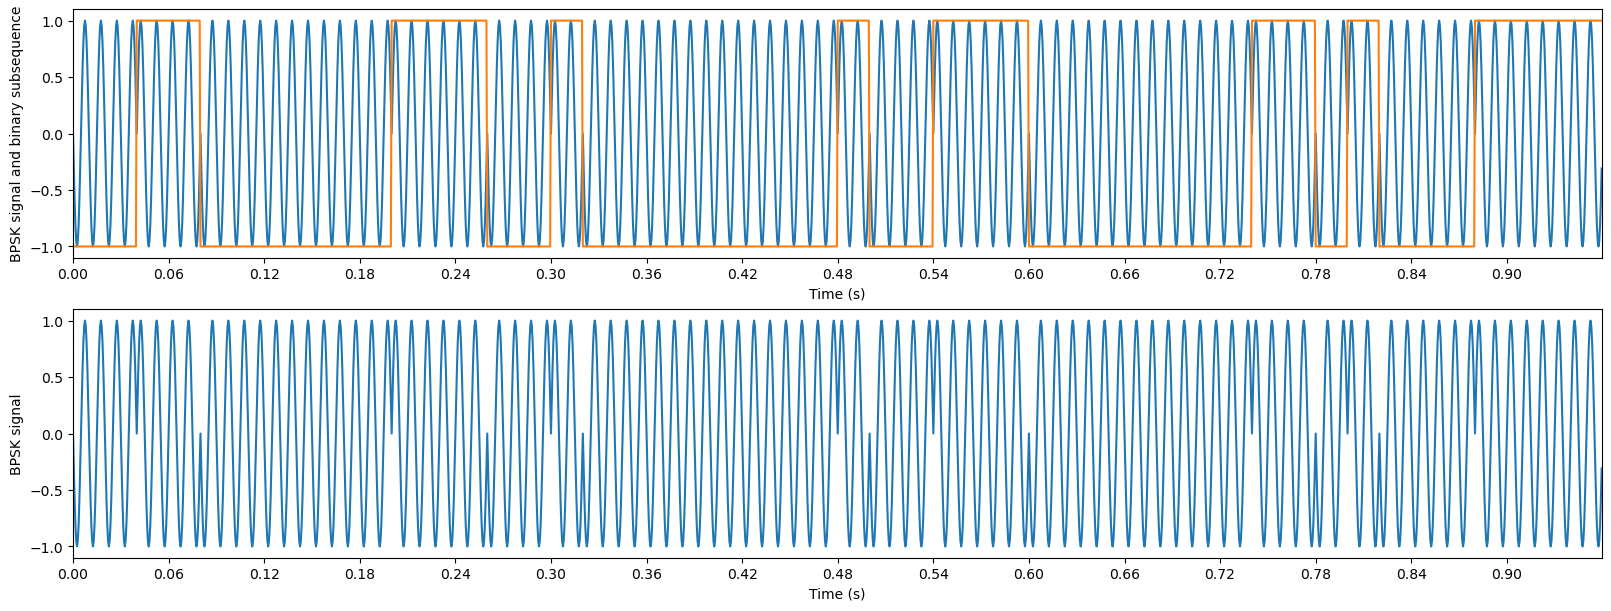

In [242]:
carrierFreq = 100
signalBPSK = getBPSKSignal(binarySignal, timeNumbers, carrierFreq)
fig,ax = plt.subplots(2, 1, layout='constrained', figsize = (16, 6))
ax[0].plot(timeNumbers, signalBPSK, timeNumbers, binarySignal)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('BPSK signal and binary subsequence')
ax[0].set_xlim(0, max(timeNumbers))
ax[0].set_xticks(np.arange(0, max(timeNumbers), len(sub)/baudRate))
ax[1].plot(timeNumbers, signalBPSK)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('BPSK signal')
ax[1].set_xlim(0, max(timeNumbers))
ax[1].set_xticks(np.arange(0, max(timeNumbers), len(sub)/baudRate))
plt.show()

In [243]:
#Усредненная теоретическая корреляционная функция ФМ-2
def R_fm2(tau, T, U0 = 1.0):
    tselect = 1 * (np.abs(tau) <= T)
    data = U0**2 / 2 * (1 - abs(tau) / T)
    return tselect * data

#Усредненная теоретическая спектральная плотность мощности ФМ-2
def G_fm2(f, T, f0, U0 = 1.0):
    return U0**2 * T * np.sinc((f - f0) * T)**2

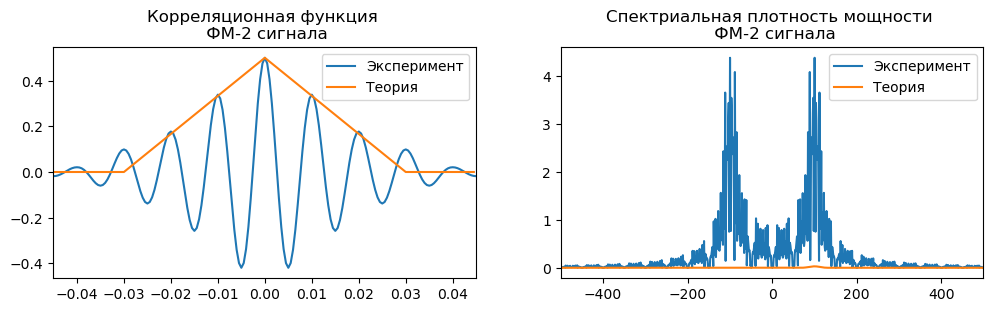

In [244]:
T = len(sub) / carrierFreq
tteor = np.arange(-1.5 * T, 1.5 * T, samplingPeriod) 
nfft = 1024 
Fmax = np.divide(1, samplingPeriod)
fteor = np.linspace(-0.5 * Fmax, 0.5 * Fmax, nfft)

Rexp_fm2 = 1 / len(signalBPSK) * np.correlate(signalBPSK, signalBPSK, mode = 'full') 
texp = np.arange(-samplingPeriod * (len(signalBPSK) - 1), samplingPeriod * len(signalBPSK), samplingPeriod)
Gexp_fm2 = np.fft.fft(signalBPSK, norm = 'forward')
Gexp_fm2 = 0.5 * (T / samplingPeriod) * Gexp_fm2
fexp = np.linspace(-0.5 * Fmax, 0.5 * Fmax, len(signalBPSK))
Gexp_fm2 = np.abs(np.fft.fftshift(Gexp_fm2))

fig5,ax5 = plt.subplots(1, 2, figsize = (12, 3))

ax5[0].plot(texp, Rexp_fm2, label = 'Эксперимент')
ax5[0].plot(tteor, R_fm2(tteor, T), label = 'Теория')
ax5[0].set_xlim(-1.5 * T, 1.5*T)
ax5[0].set_title('Корреляционная функция \n ФM-2 сигнала') 
ax5[0].legend()
ax5[1].plot(fexp, Gexp_fm2, label = 'Эксперимент')
ax5[1].plot(fteor, G_fm2(fteor, T, f0 = carrierFreq), label = 'Теория')
ax5[1].set_xlim(-0.5 * Fmax / 2, 0.5 * Fmax / 2)
ax5[1].set_title('Спектриальная плотность мощности \n ФM-2 сигнала') 
ax5[1].legend()
